# Optimization of muon track reconstruction in drift tube detectors using GPUs

## Introduction

This project involves processing data collected by a series of three particle detectors, referred to as "Superlayers" (SL). For simplicity, we will focus on the middle Superlayer.

![Experimental setup: a set of three drift tube chambers called Superlayers.](./figures/dts-telescope.png)

Each Superlayer consists of four layers of cells. These cells measure the time of the electronic signal generated when a charged particle passes through. When a particle ionizes the gas within a cell, the produced electrons drift at a constant velocity towards the anodic wire at the center of the cell.

![Zoom of a cell within the macrocell.](./figures/dts-macrocell-with-cell.png)

Our goal is to precisely determine the position where a particle traversed a cell. By combining information from four consecutive cells, we can deduce the particle's trajectory.

![A muon crossing the macrocell with explicit left-right ambiguity.](./figures/lr-ambiguity.png)

In the illustration above, the charged particle is represented by the red arrow. The four layers of cells are visible, with two cells per layer shown (the actual detector has 16 cells per layer). The black dots represent the anodic wires. Each cell measures the ionization signal time relative to a global counter. The actual drift time, which is the time taken by the ionization to reach the anodic wire, is given by 

$$
t_{\text{drift}} = t - t_{0}
$$

where \(t\) is the time recorded by the electronics and $t_0$ is a time pedestal that needs to be determined. This pedestal corresponds to the time when the particle crosses the cell. We determine $t_0$ using two scintillator tiles placed above and below the middle Superlayer, providing an external timing reference relative to the same global counter introduced earlier.

From the drift time, we can determine the position where the particle crossed the cell:

$$
x = \pm \, v_{\text{drift}} \, (t - t_0) = \pm \, v_{\text{drift}} \, t_{\text{drift}}
$$

Notice that by measuring the position of the muon from the drift time we introduce a left-right ambiguity. The muon could have crossed the cell from the left or the right.

## Dataset

The data were acquired using a system that reads the detector sensors at 40 MHz (every 25 ns), without the need for an external trigger. To limit bandwidth, a "zero-suppression" is applied, meaning data is recorded only when there is a hit in a cell.
The raw data, originally in hexadecimal format, have been preprocessed into CSV files. Each row contains 6 fields encoding the address of the readout channel (i.e., the cell) and the actual time measurement:

- **HEAD**: always 1 (not used)
- **FPGA**: 0 or 1
- **TDC_CHANNEL**: in the range 0-127, with special value 128
- **ORB_CNT**: in the range \(0-2^{32}\)
- **BX**: in the range 0-3564
- **TDC_MEAS**: in the range 1-30

The channel mapping to the detectors is as follows:

- Detector 1 → FPGA 0, TDC_CHANNEL in [0-63]
- Detector 2 → FPGA 0, TDC_CHANNEL in [64-127]
- Detector 3 → FPGA 1, TDC_CHANNEL in [0-63]
- Detector 4 → FPGA 1, TDC_CHANNEL in [64-127]

The time measurement is coded similarly to standard time (h:m:s). The time in nanoseconds is given by:

$$
t=ORB\_CNT*3564*25+BX*25+TDC\_MEAS*25/30
$$

Each row in the dataset represents a hit in the detector.

## Preprocessing step-by-step

### Import modules and libraries

In [14]:
from Constants      import Constants
from Configurations import SLConfig, DataConfig
from preprocessing  import *

from PLOTutils import *


import pandas as pd
import numpy  as np
import cupy   as cp

import cudf

import matplotlib.pyplot as plt

import hist
import mplhep as hep
hep.style.use("CMS")

import warnings
warnings.filterwarnings("ignore")

### Constants

In [15]:
DATA_PATH = "../data/parquet_all/"

### Step-by-step procedure 

#### Init experiment configuration

In [16]:
constants   = Constants()

data_config = DataConfig(data_dir=DATA_PATH)
sl_config   = SLConfig()

#### Read data from files

In [17]:
raw_data = read_data(data_config, n_files=6)

print("Raw data shape: ", raw_data.shape)
raw_data.head()

Raw data shape:  (1995331, 6)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,2,0,63,426987680,1014,14
1,2,0,125,426987680,1016,24
2,2,1,33,426987712,21,13
3,2,0,108,426987776,3436,17
4,2,0,97,426987776,273,14


#### Split data into valid hits and scintillator hits

The first thing to do is split the hits between valid DT hits (used to reconstruct the muon track) and the scintillator hits (used to determine the time pedestal). The scintillator hits are identified by the TDC_CHANNEL value 128, FPGA 1 and HEAD 2. The valid DT hits are identified by the TDC_CHANNEL value in the range [0-127], and HEAD 2.

In [18]:
# split data into data and scintillator dataframes
hits_df, scint_df = split_data_scint(raw_data, data_config)

print("Number of triggers:", scint_df.shape[0])

Number of triggers: 2703


#### Convert TDC to nano-seconds

We then convert the timing information from arbitrary units (related to the global counter) to nanoseconds.

In [19]:
scint_df = convert_tdc_to_ns(scint_df, "t0_ns", constants)
hits_df  = convert_tdc_to_ns(hits_df, "tdc_ns", constants)

#### Keep hits within a time window around the scintillator hit

we select only DT hits in the same orbit (i.e., withing ~90 microseconds) as the scintillator hits, as most DT hits come from the intrinsic background and are not related to the muon track. It is a rough approximation that is more than enough for our purposes, as the probability of two muons crossing the detector in the same orbit is negligible. For these hits, we also calculate the drift time.

In [20]:
# select hits that are within the orbit of the scintillator triggers
hits_df = select_hits_within_orbit(hits_df, scint_df, data_config)

print("Number of hits:", hits_df.shape[0])
hits_df.head()

Number of hits: 31971


,FPGA,TDC_CHANNEL,ORBIT_CNT,t0_ns,t_drift
0,1,6,427163072,26196.666667,82.683333
1,0,83,427163072,26196.666667,14.350000
2,0,26,427163072,26196.666667,40.183333
3,0,80,427163072,26196.666667,18.516667
4,1,8,427163072,26196.666667,77.683333


#### SuperLayer (SL) and Layer assignment

We use the combination of FPGA and TDC_CHANNEL to assign the hits to the corresponding SL and layer.

In [21]:
hits_df = assign_layer_and_sl(hits_df, sl_config)
hits_df.head()

,FPGA,TDC_CHANNEL,ORBIT_CNT,t0_ns,t_drift,SL,LAYER
0,1,6,427163072,26196.666667,82.683333,2,3
1,0,19,427163072,26196.666667,14.350000,1,1
2,0,26,427163072,26196.666667,40.183333,0,3
3,0,16,427163072,26196.666667,18.516667,1,4
4,1,8,427163072,26196.666667,77.683333,2,4


#### Occupancy plots

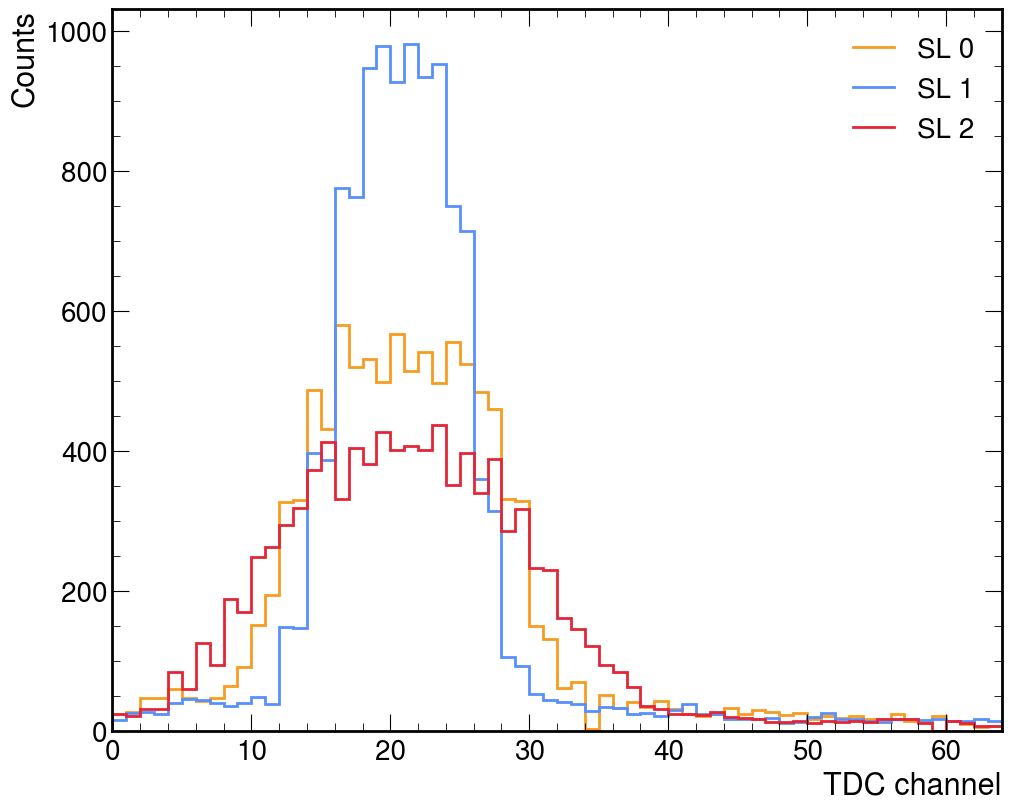

In [22]:
occupancy_hist = hist.Hist(
    hist.axis.Regular(64, 0, 64, name="Channel", label="Channel"),
    hist.axis.Regular(3, 0, 3,   name="SL",      label="SL"),
)

occupancy_hist.fill(hits_df["TDC_CHANNEL"].to_numpy(), hits_df["SL"].to_numpy())

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, fontsize=FONTSIZE)
set_tick_font(ax, fontsize=FONTSIZE-2)

hep.histplot(occupancy_hist[:,0j].project("Channel"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[1], label="SL 0")
hep.histplot(occupancy_hist[:,1j].project("Channel"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="SL 1")
hep.histplot(occupancy_hist[:,2j].project("Channel"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[2], label="SL 2")

ax.legend(fontsize=FONTSIZE-2)

ax.set_xlabel("TDC channel")
ax.set_ylabel("Counts")

ax.set_xlim(0, 64)

plt.show()

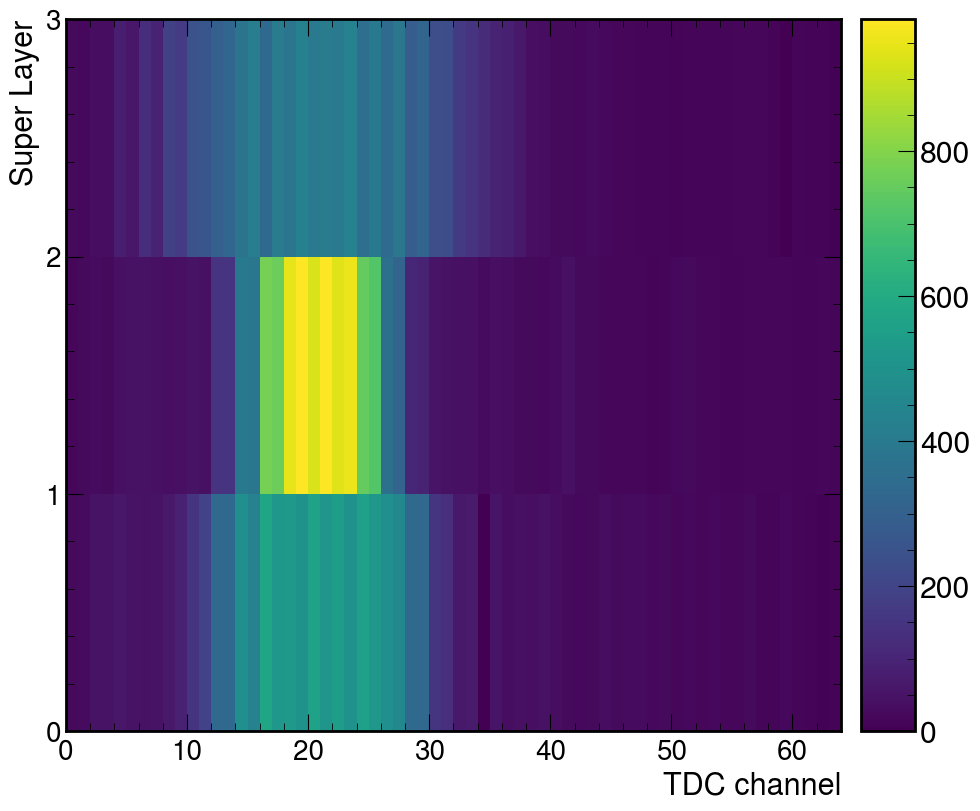

In [23]:
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, fontsize=FONTSIZE)
set_tick_font(ax, fontsize=FONTSIZE-2)

hep.hist2dplot(occupancy_hist, ax=ax)

ax.set_xlabel("TDC channel")
ax.set_ylabel("Super Layer")

plt.show()

#### Drift time plots

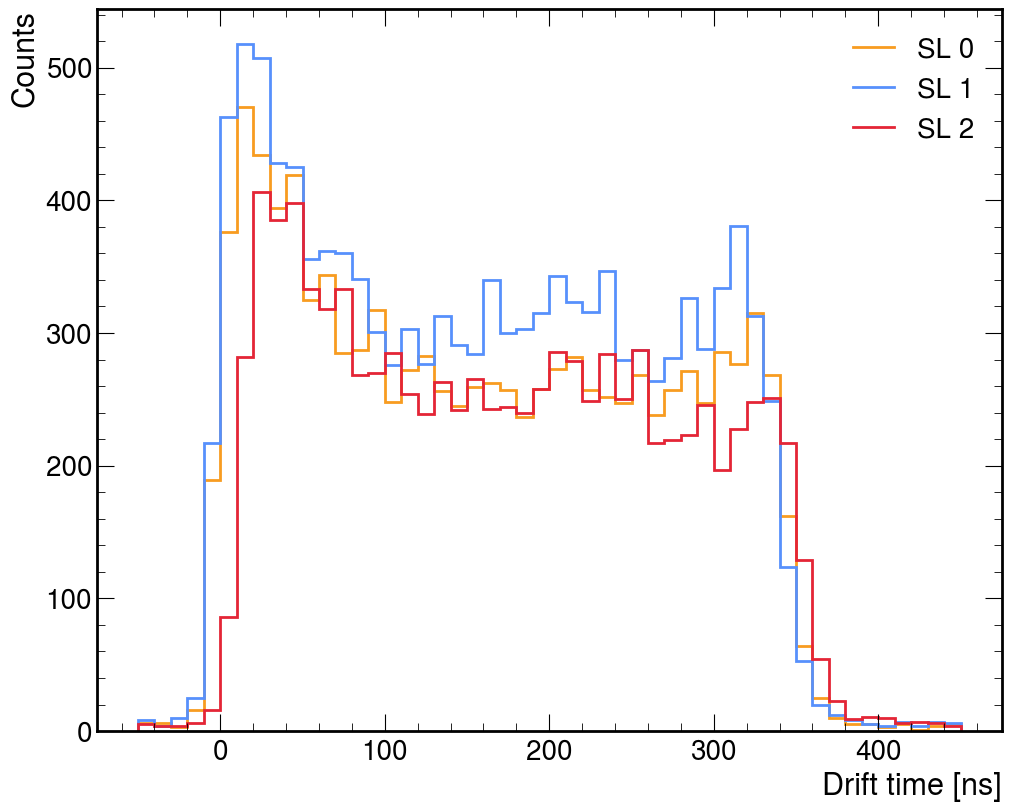

In [32]:
dt_hist = hist.Hist(
    hist.axis.Regular(50, constants.t_drift_min, constants.t_drift_max, name="drift_time", label="Drift time [ns]"),
    hist.axis.Regular(3, 0, 3,   name="SL", label="SL"),
)

dt_hist.fill(hits_df["t_drift"].to_numpy(), hits_df["SL"].to_numpy())

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, fontsize=FONTSIZE)
set_tick_font(ax, fontsize=FONTSIZE-2)

hep.histplot(dt_hist[:,0j].project("drift_time"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[1], label="SL 0")
hep.histplot(dt_hist[:,1j].project("drift_time"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="SL 1")
hep.histplot(dt_hist[:,2j].project("drift_time"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[2], label="SL 2")

ax.legend(fontsize=FONTSIZE-2)

ax.set_xlabel("Drift time [ns]")
ax.set_ylabel("Counts")

plt.show()

#### SuperLayer and Macrocell selection

We select only the region of the detector that we are interested in, which is the middle Superlayer, and specifically the region close to the scintillator tiles to maximize efficiency.

In [34]:
hits_df = select_hits_by_super_layer(hits_df, 1)
hits_df = select_hits_by_macrocell(hits_df, ch_start=8, ch_end=36)

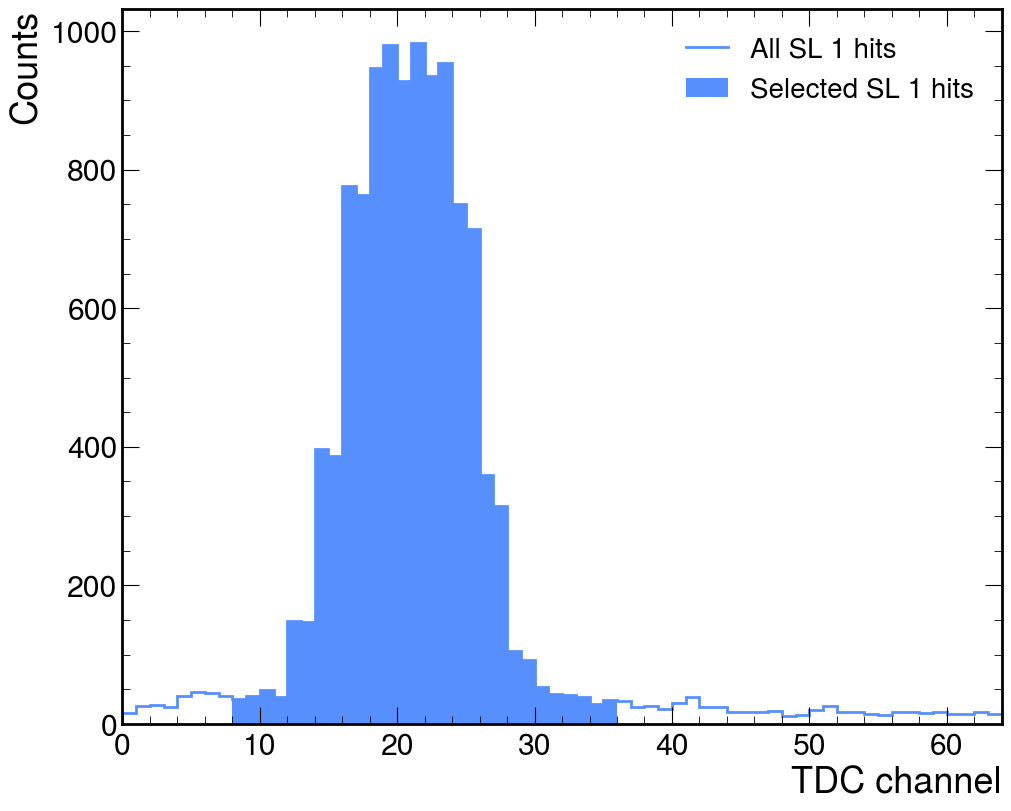

In [35]:
occupancy_hist_sl1 = hist.Hist(
    hist.axis.Regular(64, 0, 64, name="Channel", label="Channel"),
)

occupancy_hist_sl1.fill(hits_df["TDC_CHANNEL"].to_numpy())

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)

hep.histplot(occupancy_hist[:,1j].project("Channel"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="All SL 1 hits")
hep.histplot(occupancy_hist_sl1, ax=ax, histtype="fill", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="Selected SL 1 hits")

ax.set_xlabel("TDC channel")
ax.set_ylabel("Counts")

ax.set_xlim(0, 64)

ax.legend(fontsize=FONTSIZE-2)

plt.show()

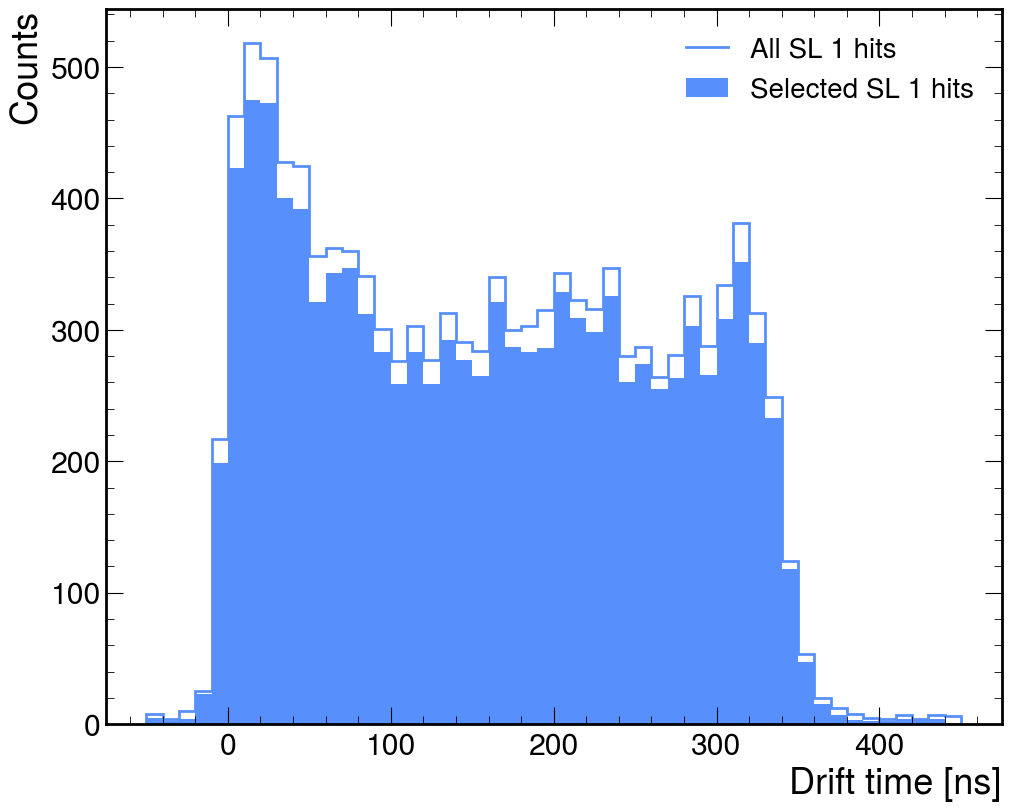

In [37]:
dt_hist_sl1 = hist.Hist(
    hist.axis.Regular(50, constants.t_drift_min, constants.t_drift_max, name="drift_time", label="Drift time [ns]"),
)

dt_hist_sl1.fill(hits_df["t_drift"].to_numpy())

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)

hep.histplot(dt_hist[:,1j].project("drift_time"), ax=ax, histtype="step", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="All SL 1 hits")
hep.histplot(dt_hist_sl1, ax=ax, histtype="fill", yerr=False, lw=2, color=CMS_PALETTE_1[0], label="Selected SL 1 hits")

ax.set_xlabel("Drift time [ns]")
ax.set_ylabel("Counts")

ax.legend(fontsize=FONTSIZE-2)

plt.show()

#### Mapping to the 3D space

We further map the hits to the 3D space in a global reference frame. The output of this operation are new columns containing the Z coordinate of the hit, the X coordinate of the hit with left-right ambiguity.

In [38]:
hits_df = map_to_global(hits_df, sl_config, constants, time_shift=0)
hits_df = compute_hit_positions(hits_df, constants)
hits_df.head()

,FPGA,TDC_CHANNEL,ORBIT_CNT,t0_ns,t_drift,SL,LAYER,WIRE_X_GLOB,WIRE_Z_GLOB,X_LEFT,X_RIGHT
1,0,19,427163072,26194.466667,14.350000,1,1,-126.0,510.25,-126.772692,-125.227308
3,0,16,427163072,26194.466667,18.516667,1,4,-147.0,549.25,-147.997051,-146.002949
8,0,17,427163072,26194.466667,133.516667,1,2,-147.0,523.25,-154.189359,-139.810641
11,0,18,427163072,26194.466667,263.516667,1,3,-126.0,536.25,-140.189359,-111.810641
16,0,14,427266720,18669.300000,34.350000,1,3,-168.0,536.25,-169.849615,-166.150385


In [39]:
hits_df = hits_df.sort_values(by="ORBIT_CNT").reset_index(drop=True)
hits_df.head()

,FPGA,TDC_CHANNEL,ORBIT_CNT,t0_ns,t_drift,SL,LAYER,WIRE_X_GLOB,WIRE_Z_GLOB,X_LEFT,X_RIGHT
0,0,23,426994112,59640.3,4.350000,1,1,-84.0,510.25,-84.234231,-83.765769
1,0,20,426994112,59640.3,151.850000,1,4,-105.0,549.25,-113.176538,-96.823462
2,0,21,426994112,59640.3,182.683333,1,2,-105.0,523.25,-114.836795,-95.163205
3,0,22,426994112,59640.3,213.516667,1,3,-84.0,536.25,-95.497051,-72.502949
4,0,21,427008000,57002.8,63.516667,1,2,-105.0,523.25,-108.420128,-101.579872


## Track reconstruction

In [40]:
event_grouped = hits_df.groupby("ORBIT_CNT")

In [42]:
event = event_grouped.get_group(426994112)
event.head()

,FPGA,TDC_CHANNEL,ORBIT_CNT,t0_ns,t_drift,SL,LAYER,WIRE_X_GLOB,WIRE_Z_GLOB,X_LEFT,X_RIGHT
0,0,23,426994112,59640.3,4.350000,1,1,-84.0,510.25,-84.234231,-83.765769
1,0,20,426994112,59640.3,151.850000,1,4,-105.0,549.25,-113.176538,-96.823462
2,0,21,426994112,59640.3,182.683333,1,2,-105.0,523.25,-114.836795,-95.163205
3,0,22,426994112,59640.3,213.516667,1,3,-84.0,536.25,-95.497051,-72.502949


In [ ]:
def linear_fit(X, Y, sigma_Y):
    """Perform a linear fit of Y = a + b * X."""
    S = cp.sum(1 / (sigma_Y ** 2))
    Sx = cp.sum(X / (sigma_Y ** 2))
    Sy = cp.sum(Y / (sigma_Y ** 2))
    Sxx = cp.sum((X ** 2) / (sigma_Y ** 2))
    Sxy = cp.sum((X * Y) / (sigma_Y ** 2))
    Delta = S * Sxx - Sx ** 2
    a = (Sxx * Sy - Sx * Sxy) / Delta
    b = (S * Sxy - Sx * Sy) / Delta
    sigma_a = cp.sqrt(Sxx / Delta)
    sigma_b = cp.sqrt(S / Delta)
    return a, b, sigma_a, sigma_b


def chisq(X, Y, SY, a, b):
    """Compute the chi-square of the fit."""
    return sum(((y - a - x * b) / sy) ** 2 for x, y, sy in zip(X, Y, SY))



def linear_reg(X, Y):
    """Perform a linear regression."""
    
    # uncertainty on the position is 400 um
    sigma_X = cp.full(len(X), 0.4)
    
    
    # perform the fit
    a, b, sigma_a, sigma_b = linear_fit(Y, X, sigma_X)
    

    # compute the chi-square
    chi2 = chisq(Y, X, sigma_X, a, b)
    dof  = len(X) - 2  # degrees of freedom
    
    # compute the chi-square compatibility with its degrees of freedom
    chisq_comp = abs(chi2 - dof) / cp.sqrt(2 * dof)

    
    return {"m": b, "q": a, "chisq_comp": chisq_comp}